## Machine Learning Techniques for Trading

##### I use a variety of Machine Learning techniques (Supervised and Unsupervised) to predict when a stock price is going up or down, this in tern is an indication of stock market movements and help the trader By Sell Stocks

In [12]:
library(lubridate)
library(quantmod)
library(tidyverse)

In [7]:
## Loading crude oil data and calculation EMAs
#load the data
price <- read.csv("wtiDaily.csv")
setup_data <- function(pricedata) {
  names(pricedata) <- c("Date", "Open", "High", "Low", "Close")
  dates <- parse_date_time(x = pricedata[,1], "mdy_HM", truncated = 3)
  pricedata <- pricedata[,2:5]
  pricedata <- xts(pricedata, order.by = dates)
  
}
price <- setup_data(price)
ema7 <- EMA(price$Close, n = 7)
ema20 <- EMA(price$Close, n = 20)

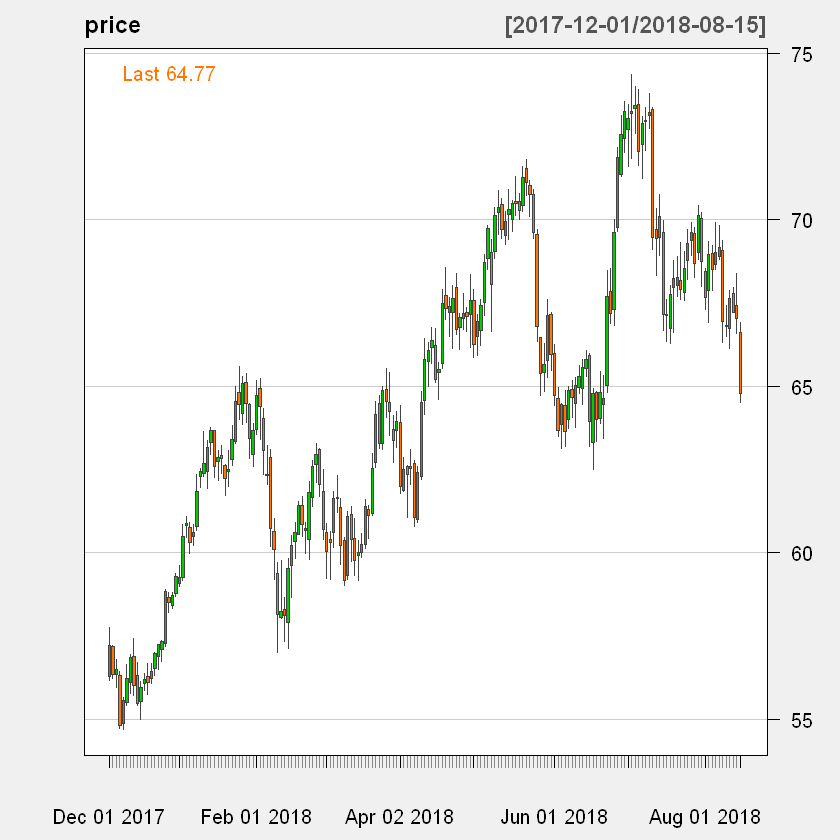

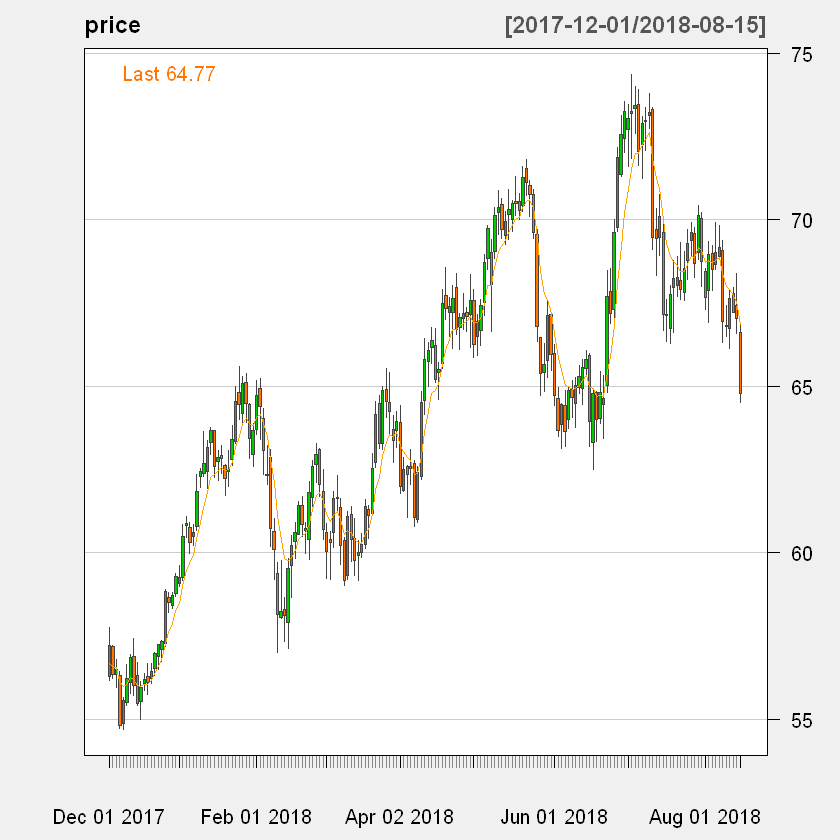

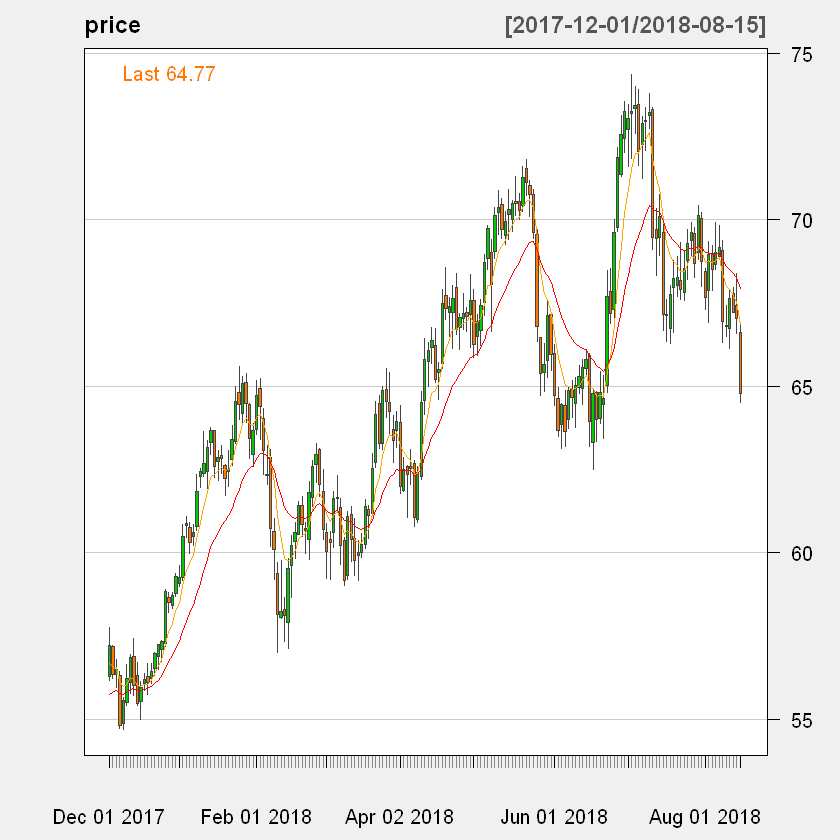

In [9]:
## Plotting the data
chartSeries(price, subset = "2017-12::", theme = "white")
addEMA( n = 7, col = "orange")
addEMA( n = 20, col = "red")

### Feature engineering - final features dataframe

In [15]:
#making the features
candle.type.current <- data.frame(ifelse(price$Close > price$Open, "bull", "bear"))
candle.type.previous <- data.frame(lag(candle.type.current$Close, n = 1))
candle.next.day <- data.frame(lead(candle.type.current$Close, n = 1))
doji <- data.frame(ifelse(abs(price$Close - price$Open) < 0.45, "yes", "no"))
position.to.ema7 <- data.frame(ifelse(price$Close > ema7, "above", "below"))
position.to.ema20 <- data.frame(ifelse(price$Close > ema20, "above", "below"))
ema7.to.ema20 <- data.frame(ifelse(ema7 > ema20, "above", "below"))
daily.return <- data.frame(abs(price$Close - price$Open))
nextday.return <- lead(daily.return$Close, n = 1)

#Making up the dataframe with all the features as columns
clData <- data.frame(candle.type.current, candle.type.previous,
                     doji, position.to.ema7, position.to.ema20, ema7.to.ema20,
                     daily.return, nextday.return, candle.next.day)

# naming the dataframe columns
names(clData) <- c("candle.type.current", "candle.type.previous",
                       "doji", "position.to.ema7", "position.to.ema20",
                       "ema7.to.ema20", "daily.return", "nextday.return", 
                       "candle.next.day")

### Feature engineering - Training and testing

In [16]:
##Training and testing
clData <- slice(clData, 21:length(clData$doji))

#Splitting the data in to train and test
trainRange <- 1:400
testRange <- 400:516
train <- clData[trainRange,]
test <- clData[testRange,]

#### Design a formula: target variables and predictors

In [18]:
target <- "candle.next.day"
predictors.var <- c("candle.type.current", "candle.type.previous",
                       "doji", "position.to.ema7", "position.to.ema20",
                       "ema7.to.ema20", "daily.return")
predictors.var <- paste(predictors.var, collapse = "+")
formula <- as.formula(paste(target, "~", predictors.var, sep = ""))

#function for processing predictions
predictedReturn <- function(df, pred) { 

    #pred is our prediction from the machine learning model
df$pred <- pred
df$prediReturn <- ifelse(df$candle.next.day != df$pred, -df$nextday.return, df$nextday.return)
df$cumReturn <- cumsum(df$prediReturn)
return(df)
}

#### Naive Bayes algorithm

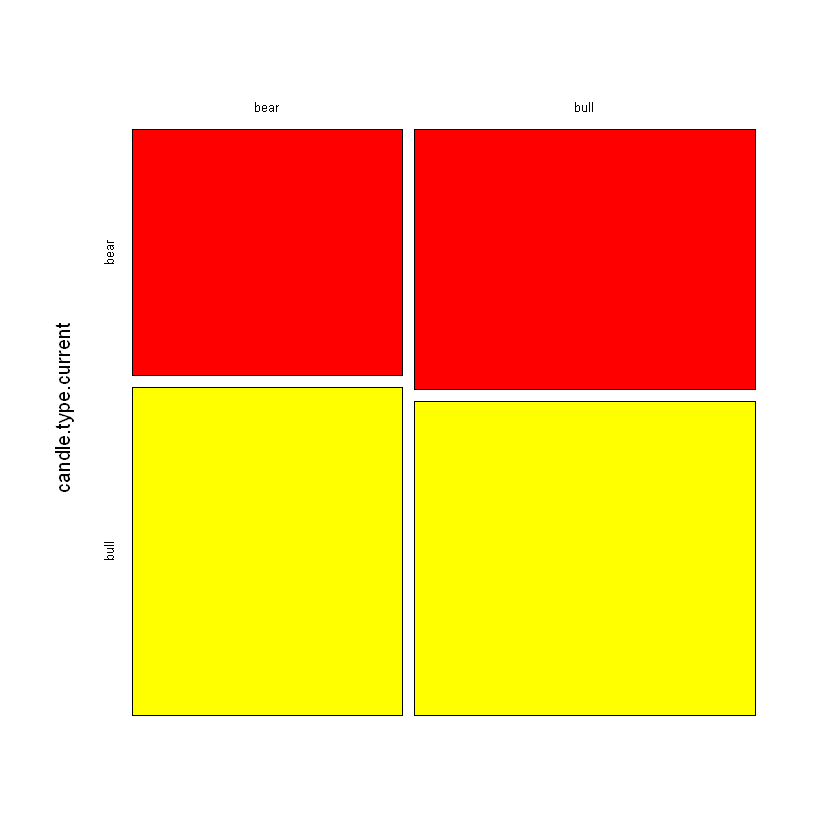

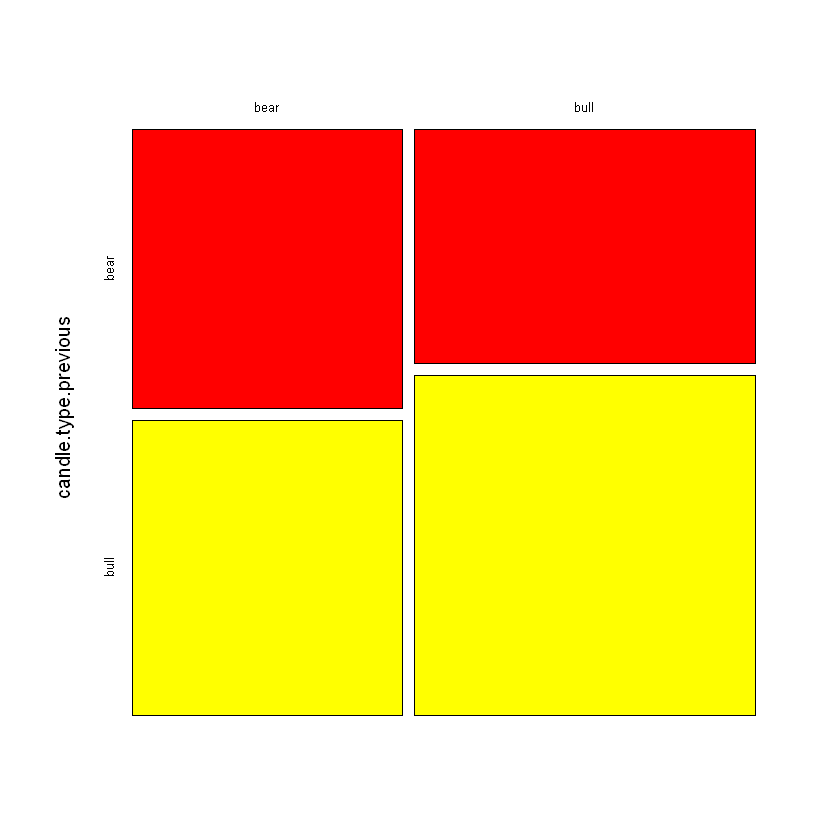

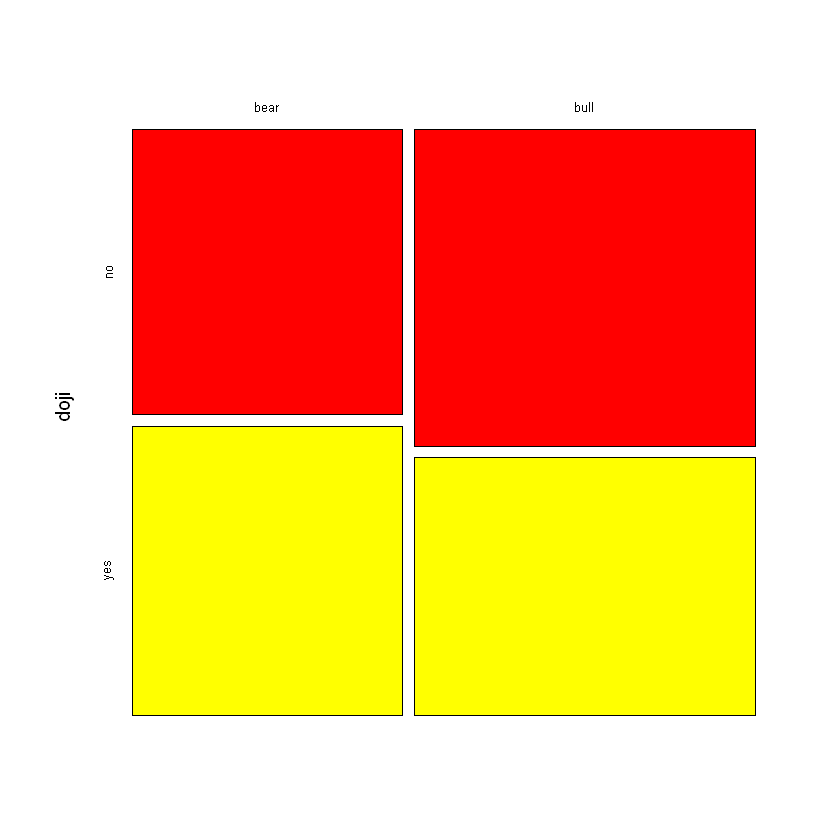

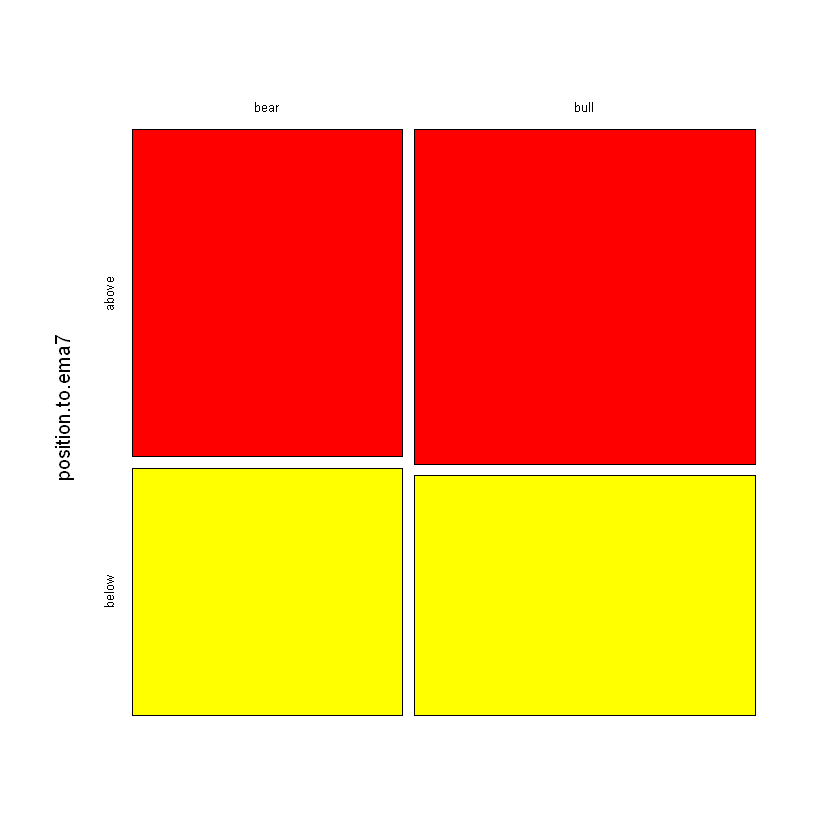

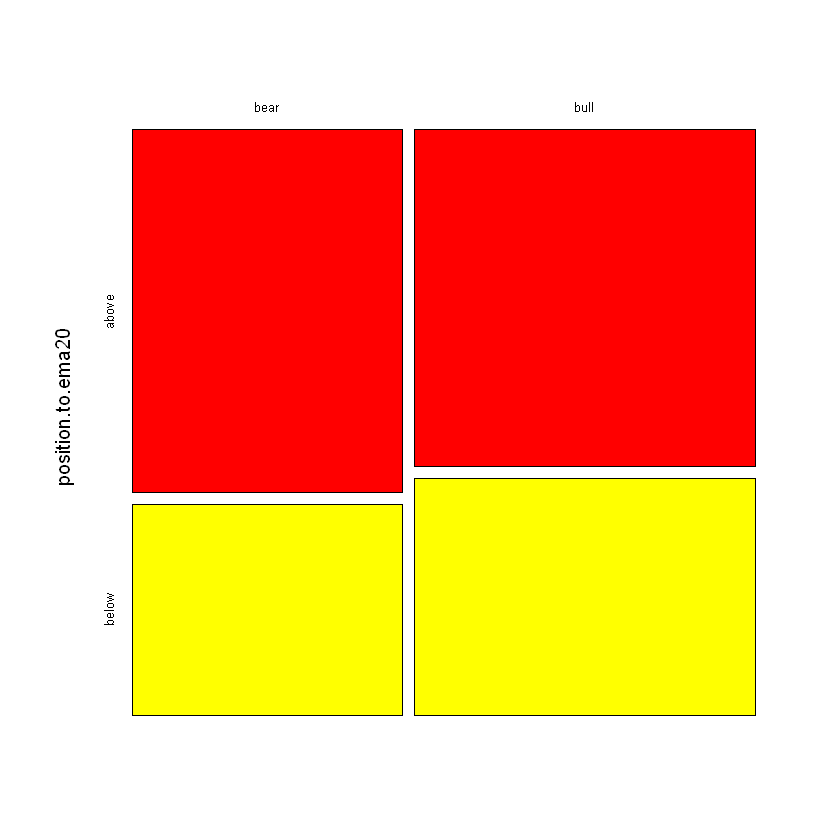

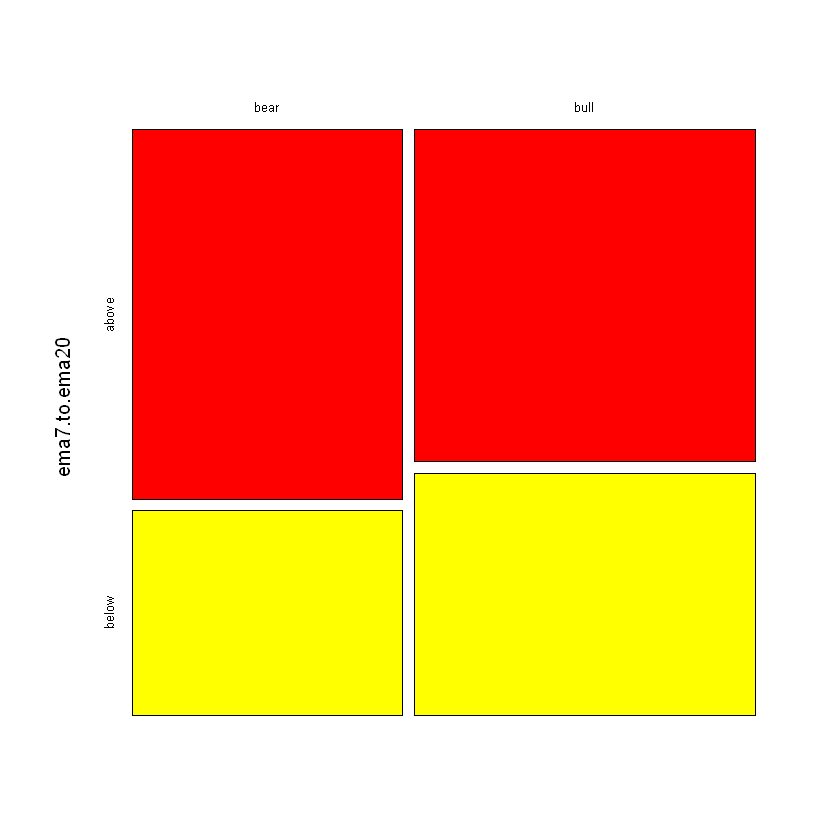

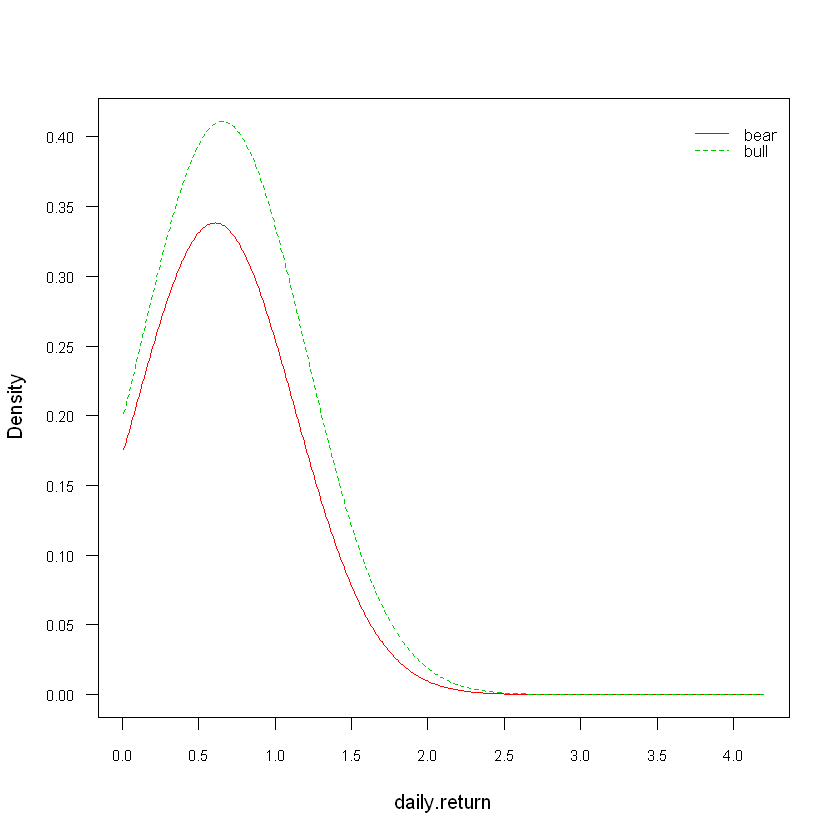

In [22]:
##Naive Bayes algorithm
library("naivebayes")

#naivebayes model
nb <- naive_bayes(formula, data = train)
plot(nb)

Warning message:
"predict.naive_bayes(): more features in the newdata are provided as there are probability tables in the object. Calculation is performed based on features to be found in the tables."Warning message in plot.xy(xy, type, ...):
"plot type 'line' will be truncated to first character"Warning message in plot.xy(xy, type, ...):
"plot type 'line' will be truncated to first character"

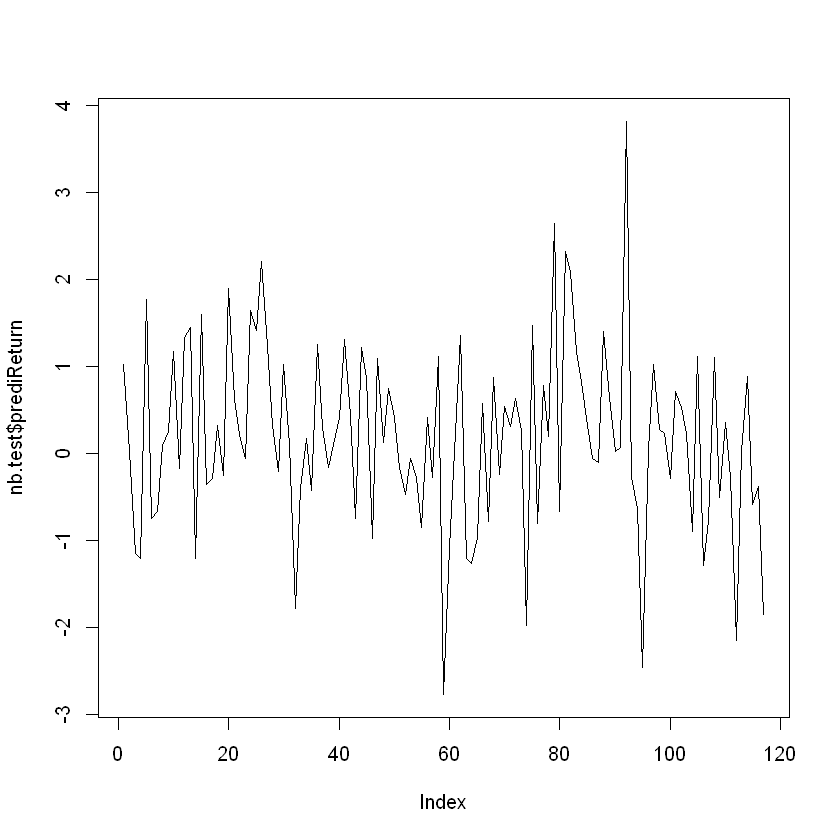

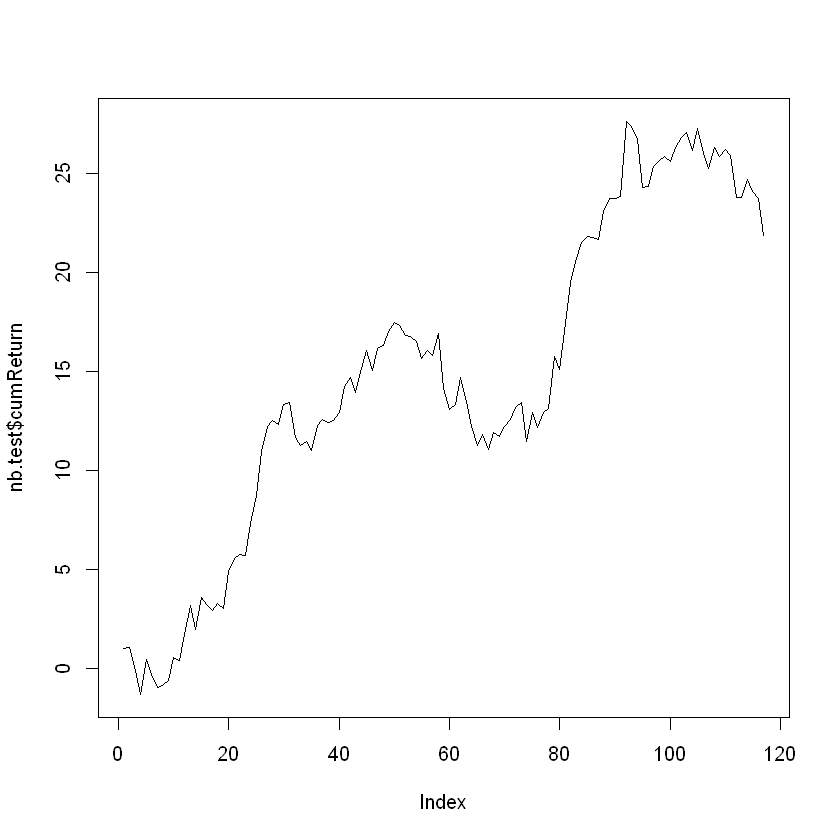

In [26]:
#prediction
nb.pred <- predict(nb, test)
nb.test <- predictedReturn(test, nb.pred)
plot(nb.test$prediReturn, type = "line")
plot(nb.test$cumReturn, type = "line")

In [25]:
#confusion matrix
confusionmatrix.nb <- table(nb.test$candle.next.day, nb.test$pred)
print(confusionmatrix.nb)

#calculating accuracy
nb.error <- mean(nb.test$candle.next.day != nb.test$pred)
print(paste("Accuracy", 1 - nb.error))

      
       bear bull
  bear   14   35
  bull   13   55
[1] "Accuracy 0.58974358974359"


#### Support vector machine

In [30]:
##Support vector machine
library("e1071")

#svm model
model.svm <- svm(formula, data = train, kernel = "radial" )

#prediction
svm.pred <- predict(model.svm, test)

Warning message in plot.xy(xy, type, ...):
"plot type 'line' will be truncated to first character"Warning message in plot.xy(xy, type, ...):
"plot type 'line' will be truncated to first character"

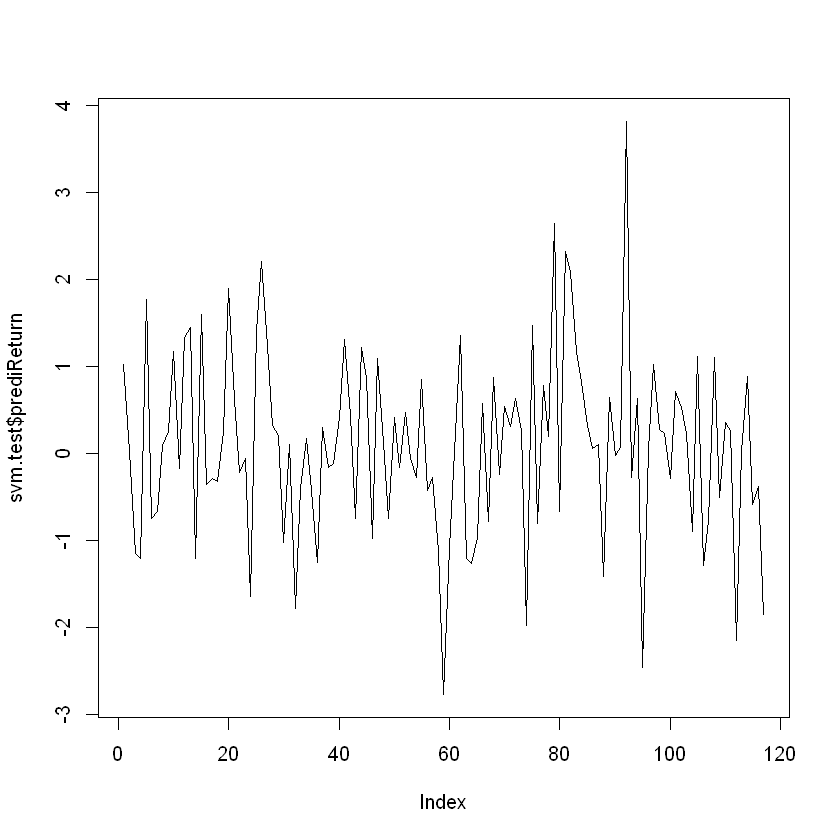

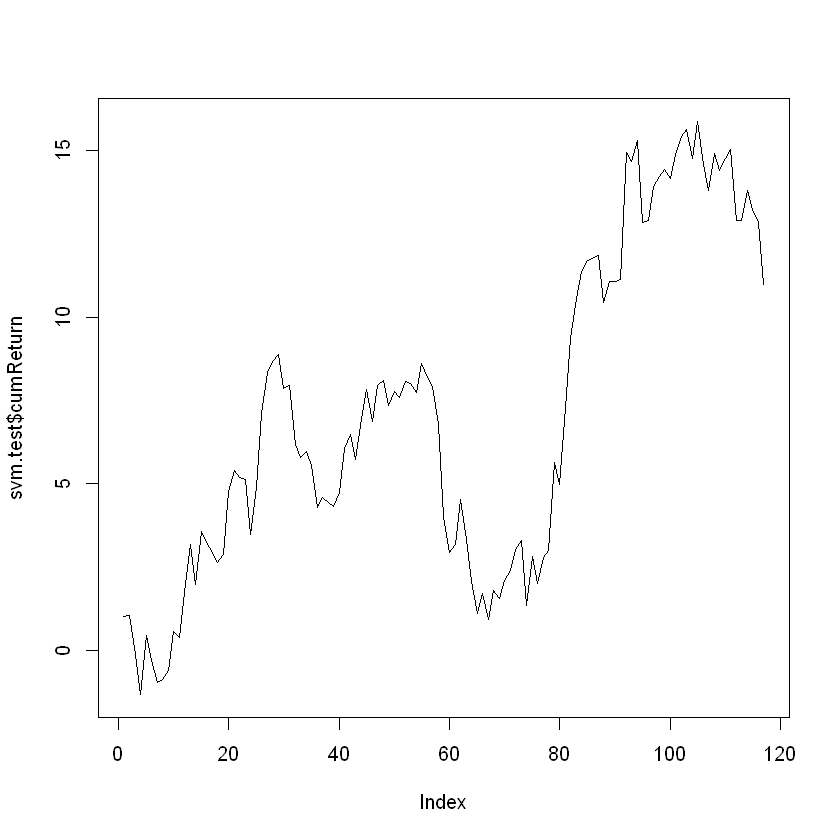

In [31]:
#results
svm.test <- predictedReturn(test, svm.pred)
plot(svm.test$prediReturn, type = "line")
plot(svm.test$cumReturn, type = "line")

In [32]:
#confusion matrix
confusionmatrix.svm <- table(svm.test$candle.next.day, svm.test$pred)
print(confusionmatrix.svm)

#calculating accuracy
svm.error <- mean(svm.test$candle.next.day != svm.test$pred)
print(paste("Accuracy", 1 - svm.error))

      
       bear bull
  bear    3   46
  bull    5   63
[1] "Accuracy 0.564102564102564"


#### Random Forest

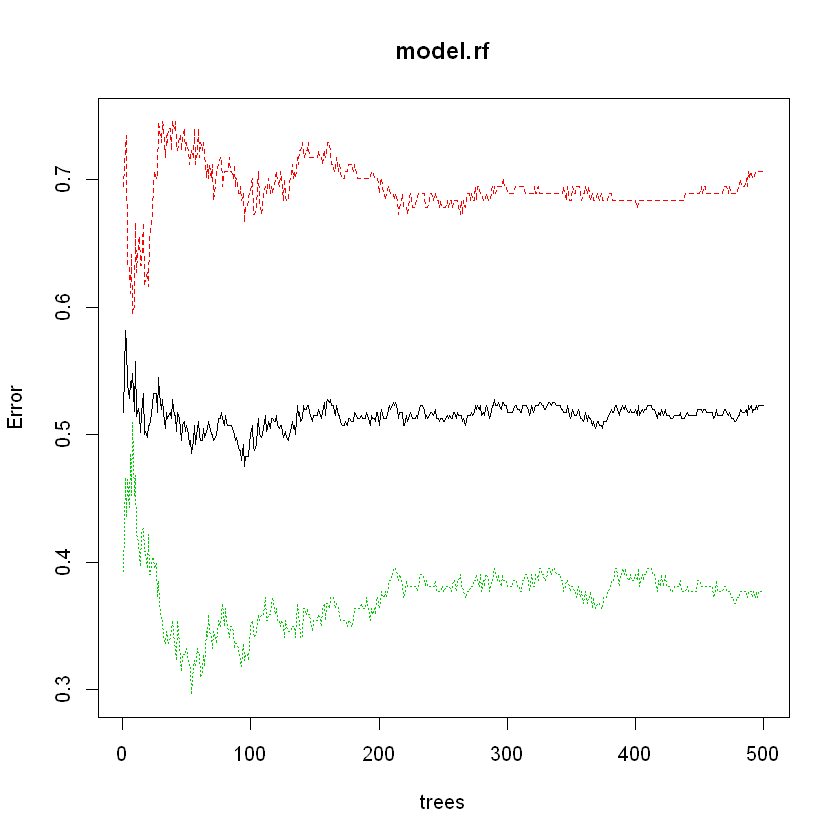

Warning message in plot.xy(xy, type, ...):
"plot type 'line' will be truncated to first character"

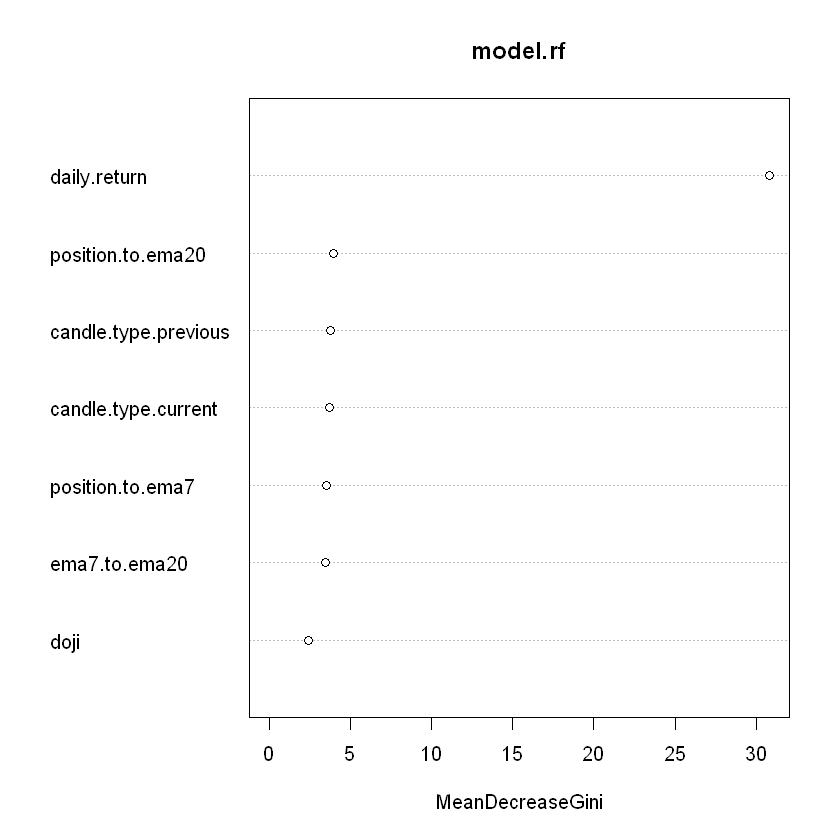

Warning message in plot.xy(xy, type, ...):
"plot type 'line' will be truncated to first character"

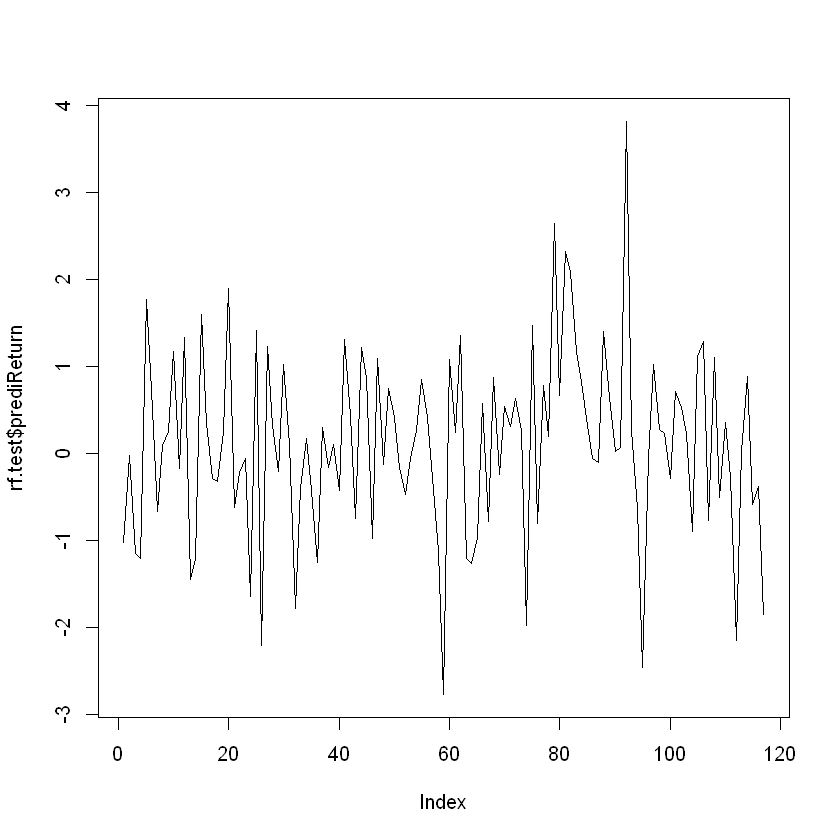

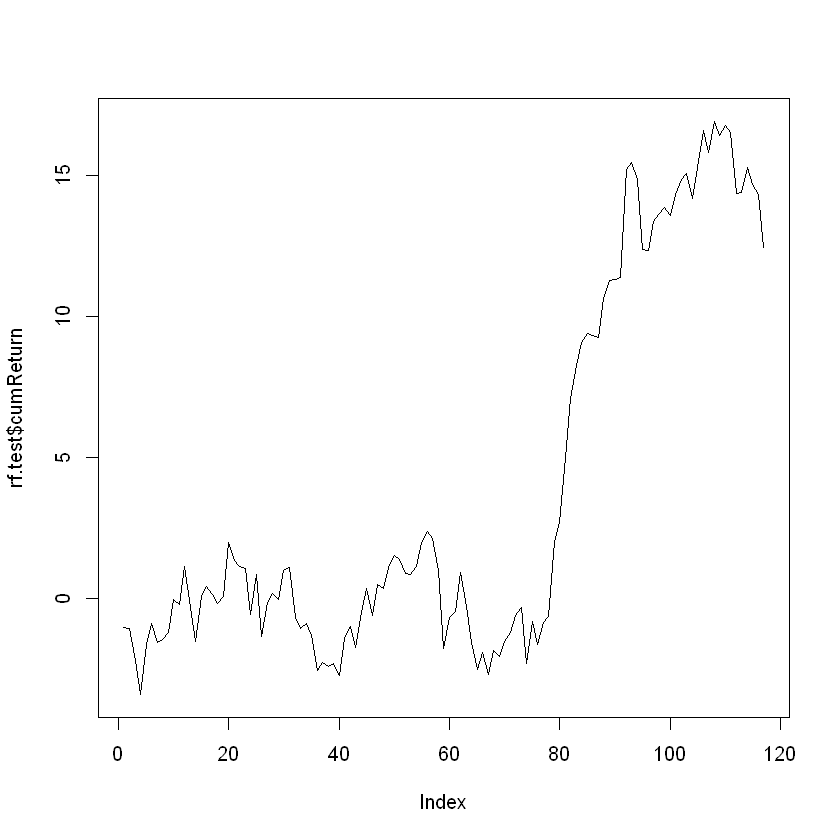

In [36]:
##Random Forest
library("randomForest")

#random model
model.rf <- randomForest(formula, data = train, ntree = 500)
plot(model.rf)
varImpPlot(model.rf)

#prediction
rf.pred <- predict(model.rf, test)

#results
rf.test <- predictedReturn(test, rf.pred)
plot(rf.test$prediReturn, type = "line")
plot(rf.test$cumReturn, type = "line")

In [37]:
#confusion matrix
confusionmatrix.rf <- table(rf.test$candle.next.day, rf.test$pred)
print(confusionmatrix.rf)

#calculating accuracy
rf.error <- mean(rf.test$candle.next.day != rf.test$pred)
print(paste("Accuracy", 1 - rf.error))

      
       bear bull
  bear   16   33
  bull   19   49
[1] "Accuracy 0.555555555555556"


### Backtesting and performance comparison of the models

In [39]:
## Backtesting and performance comparison of the models
#{r, echo = FALSE}
library("ggplot2")
nb.cumReturn <- nb.test$cumReturn
svm.cumReturn <- svm.test$cumReturn
rf.cumReturn <- rf.test$cumReturn
total.cumReturn <- nb.cumReturn + svm.cumReturn + rf.cumReturn
names(nb.cumReturn) <- "cumreturn"
names(svm.cumReturn) <- "cumreturn"
names(rf.cumReturn) <- "cumreturn"
combined.cumReturn <- data.frame(c(1:length(nb.cumReturn)), nb.cumReturn, svm.cumReturn, rf.cumReturn, total.cumReturn)

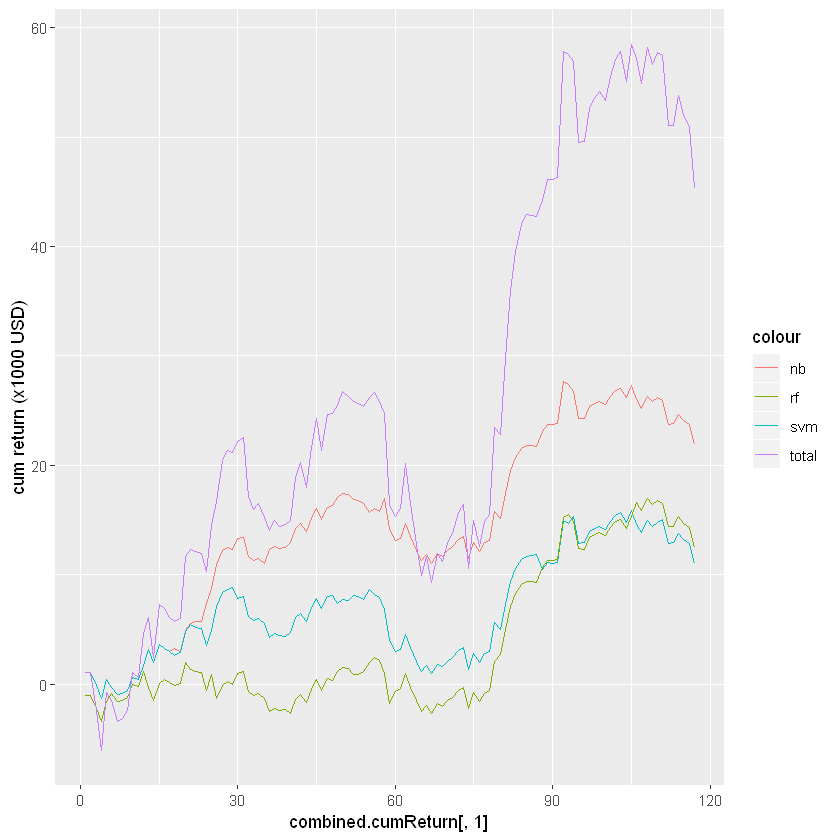

In [40]:
#plot the cumReturn of all the ML models
print(ggplot(combined.cumReturn) 
      + geom_line(aes(combined.cumReturn[,1], nb.cumReturn, colour = "nb"))
      + geom_line(aes(combined.cumReturn[,1], svm.cumReturn, colour = "svm"))
      + geom_line(aes(combined.cumReturn[,1], rf.cumReturn, colour = "rf"))
      + geom_line(aes(combined.cumReturn[,1], total.cumReturn, colour = "total"))
      + ylab("cum return (x1000 USD)")
   
)

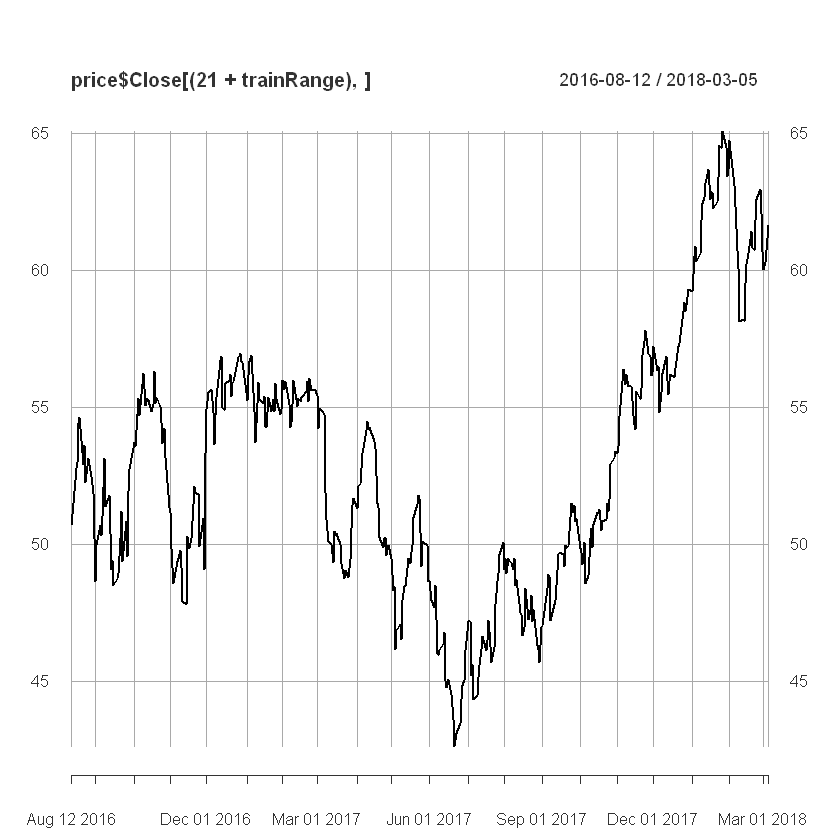

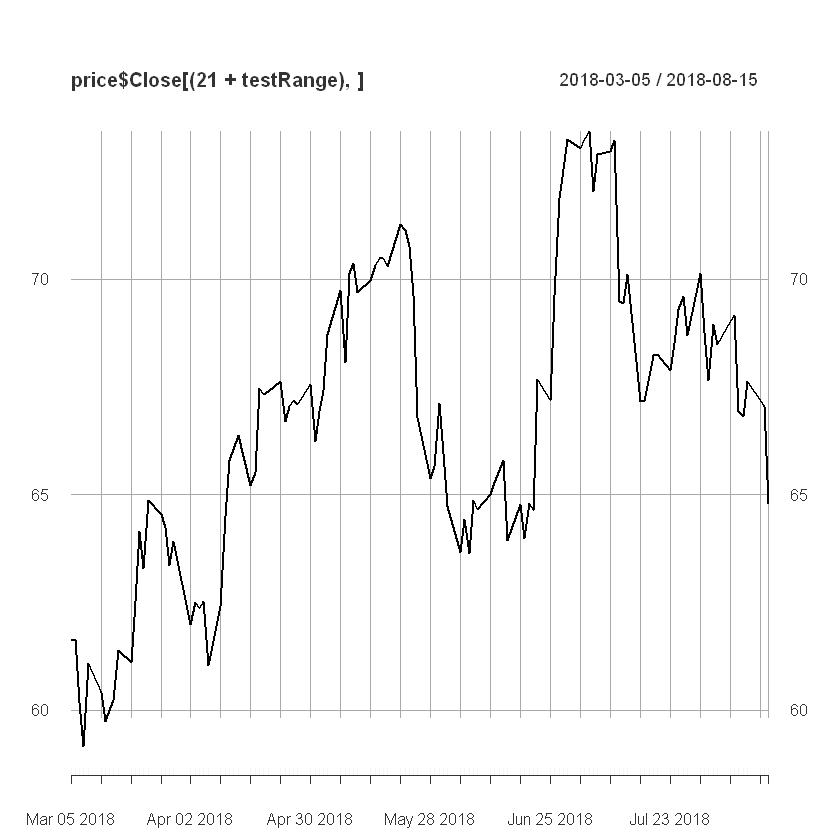

In [41]:
#plot the training and testing set (close price)
plot(price$Close[(21 + trainRange), ])
plot(price$Close[(21 + testRange), ])

In [42]:
#printing training, testing range and accuracies
print(paste("train:", rownames(train[1,]), ":", rownames(train[length(train$doji),])))
print(paste("test:", rownames(test[1,]), ":", rownames(test[length(test$doji),])))
print(paste("accuracy:", "nb:" , round(1 - nb.error, 2),
                         "svm:" , round(1 - svm.error, 2), 
                         "rf:" , round(1 - rf.error, 2) ))

[1] "train: 1 : 400"
[1] "test: 400 : 516"
[1] "accuracy: nb: 0.59 svm: 0.56 rf: 0.56"
